In [ ]:
!pip install gdown

!gdown --id 1QKYRzRFm37H-6XIc7XrlPp6T6BF0IceJ
!unzip "/content/fruit_dataset.zip"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


import modules

In [ ]:
!pip install split-folders
import splitfolders  
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import keras
from tensorflow.keras.utils import to_categorical
import glob
import cv2
import os
from keras.models import Sequential
import tensorflow
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.layers import LSTM, Input, TimeDistributed
from keras.models import Model
from keras import optimizers
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import RMSprop, SGD, Adadelta
from keras import backend as K
from sklearn.metrics import confusion_matrix,classification_report
from PIL import Image
import shutil


In [ ]:
splitfolders.ratio("fruit_dataset/fruits/", output= "output/", seed=1337, ratio=(.8, .1,.1), group_prefix=None) 

Copying files: 15880 files [00:02, 6406.03 files/s]


In [ ]:
# visualization method
def visualize(x, y, p):
    indices = np.random.choice(range(x.shape[0]), 10, replace = False)
    
    x = x[indices]
    y = y[indices]
    p = p[indices]
    
    plt.figure(figsize = (10, 5))
    for i in range(10):
        plt.subplot(2, 5, 1 + i)
        plt.imshow(x[i])
        plt.xticks([])
        plt.yticks([])
        col = 'blue' if np.argmax(y[i]) == np.argmax(p[i]) else 'red'
        plt.xlabel(classnames[np.argmax(p[i])], color = col)
    plt.show()
    

In [ ]:
# data preprcoessing method
def data(path):
  images = []
  labels = [] 
  for path in glob.glob(path):
    image_label = path.split("/")[-1]
    for image_path in glob.glob(os.path.join(path, "*.*")):
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        image = cv2.resize(image, (45, 45))
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        images.append(image)
        labels.append(image_label)
  images = np.array(images)
  labels = np.array(labels)
  return images,labels


train set

In [ ]:
images, labels = data("/content/drive/MyDrive/Top Indian Fruits Dataset_Clean Images/output/train/*")

In [ ]:
label_to_id_dict = {v:i for i,v in enumerate(np.unique(labels))}
id_to_label_dict = {v: k for k, v in label_to_id_dict.items()}
id_to_label_dict

{0: 'Orange_Bad',
 1: 'Orange_Good',
 2: 'Pomegranate_Bad',
 3: 'Pomegranate_Good'}

In [ ]:
classnames = [i for i in id_to_label_dict.values()]
label_ids = np.array([label_to_id_dict[x] for x in labels])
images.shape, label_ids.shape, labels.shape

((12700, 45, 45, 3), (12700,), (12700,))

validation set

In [ ]:
valimages, vallabels = data("output/val/*")

In [ ]:
validation_label_ids = np.array([label_to_id_dict[x] for x in vallabels])
valimages.shape, validation_label_ids.shape

((1585, 45, 45, 3), (1585,))

In [ ]:
datadir = '/content/output/'
traindir = datadir + 'train/'
validdir = datadir + 'val/'
testdir = datadir + 'test/'

ctg_lst = []
img_ctg = []
train = []
valid = []
test = []

for d in os.listdir(traindir):
    ctg_lst.append(d)

    train_imgs = os.listdir(traindir + d)
    valid_imgs = os.listdir(validdir + d)
    test_imgs = os.listdir(testdir + d)
    train.append(len(train_imgs))
    valid.append(len(valid_imgs))
    test.append(len(test_imgs))

    for i in train_imgs:
        img_ctg.append(d)
        img = Image.open(traindir + d + '/' + i)
        img_array = np.array(img)

ctg_df = pd.DataFrame({'category': ctg_lst,
                       'train': train,
                       'validation': valid, 'test': test})


In [ ]:
fruit_df = ctg_df.sort_values(by=['category'], ascending=True)
fruit_df

,category,train,validation,test
8,Apple_Bad,1280,160,161
11,Apple_Good,1116,139,140
12,Banana_Bad,1224,153,153
13,Banana_Good,1104,138,139
10,Guava_Bad,800,100,100
3,Guava_Good,800,100,100
0,Lime_Bad,800,100,100
7,Lime_Good,1220,152,154
6,Orange_Bad_4,800,100,100
4,Orange_Bad_5,322,40,41


Text(0.5, 1.0, 'No Of Training Images')

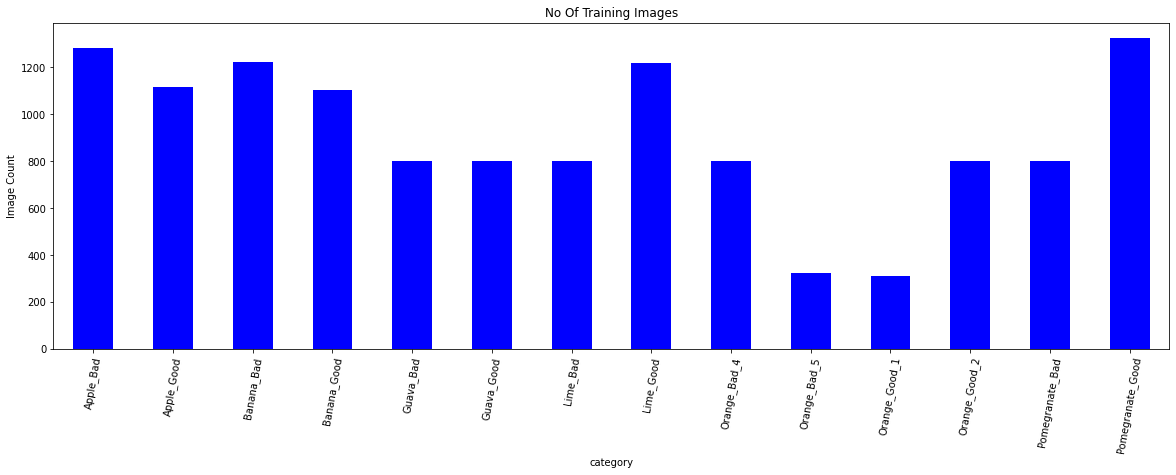

In [ ]:
fruit_df.set_index('category')['train'].plot.bar(
    color='b', figsize=(20, 6))
plt.xticks(rotation=80)
plt.ylabel('Image Count')
plt.title('No Of Training Images')

In [ ]:
X_train, X_test = images, valimages
Y_train, Y_test = label_ids, validation_label_ids

#Normalize color values to between 0 and 1
X_train = X_train/255
X_test = X_test/255

#Make a flattened version for some of our models
X_flat_train = X_train.reshape(X_train.shape[0], 45*45*3)
X_flat_test = X_test.reshape(X_test.shape[0], 45*45*3)

#One Hot Encode the Output
Y_train = to_categorical(Y_train, 14)
Y_test = to_categorical(Y_test, 14)

print('Original Sizes:', X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)
print('Flattened:', X_flat_train.shape, X_flat_test.shape)

Original Sizes: (12700, 45, 45, 3) (1585, 45, 45, 3) (12700, 14) (1585, 14)
Flattened: (12700, 6075) (1585, 6075)


In [ ]:
print(X_train.shape)
print(Y_train.shape)

(12700, 45, 45, 3)
(12700, 14)


(45, 45, 3)


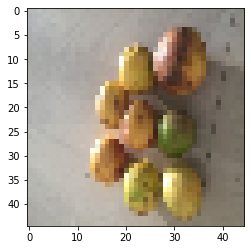

In [ ]:
print(X_train[0].shape)
plt.imshow(X_train[0])
plt.show()

visualizing train set

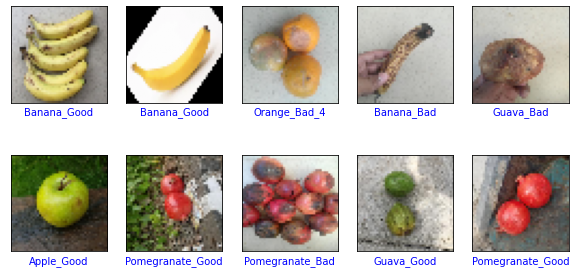

In [ ]:
visualize(X_train, Y_train, Y_train)

Epoch 1/40
397/397 [==============================] - 14s 13ms/step - loss: 1.4407 - accuracy: 0.4898 - val_loss: 0.8167 - val_accuracy: 0.7129
Epoch 2/40
397/397 [==============================] - 5s 12ms/step - loss: 0.5802 - accuracy: 0.8020 - val_loss: 0.3287 - val_accuracy: 0.8984
Epoch 3/40
397/397 [==============================] - 5s 12ms/step - loss: 0.3391 - accuracy: 0.8883 - val_loss: 0.2673 - val_accuracy: 0.9142
Epoch 4/40
397/397 [==============================] - 5s 12ms/step - loss: 0.2467 - accuracy: 0.9178 - val_loss: 0.2007 - val_accuracy: 0.9407
Epoch 5/40
397/397 [==============================] - 5s 12ms/step - loss: 0.1933 - accuracy: 0.9367 - val_loss: 0.2139 - val_accuracy: 0.9350
Epoch 6/40
397/397 [==============================] - 5s 12ms/step - loss: 0.1814 - accuracy: 0.9430 - val_loss: 0.1772 - val_accuracy: 0.9527
Epoch 7/40
397/397 [==============================] - 5s 12ms/step - loss: 0.1433 - accuracy: 0.9548 - val_loss: 0.1601 - val_accuracy: 0.950

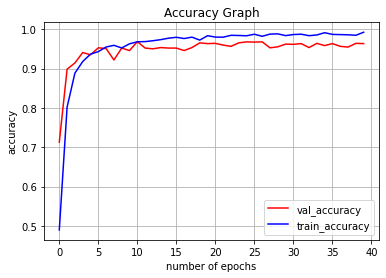

In [ ]:
model_cnn = Sequential()

model_cnn.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(45, 45, 3)))
model_cnn.add(Conv2D(64,kernel_size=(3, 3), activation='relu'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))
model_cnn.add(Dropout(0.5))
model_cnn.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model_cnn.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))


model_cnn.add(Flatten())
model_cnn.add(Dense(512*4, activation='relu'))
model_cnn.add(Dropout(0.5))
model_cnn.add(Dense(1024, activation='relu'))
model_cnn.add(Dense(256, activation='relu'))
model_cnn.add(Dense(14, activation='softmax'))

model_cnn.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=tensorflow.keras.optimizers.Adam(),
              metrics=['accuracy'])

history_cnn = model_cnn.fit(X_train, Y_train,
          batch_size=32,
          epochs=40,
          verbose=1,
          validation_data=(X_test, Y_test))
score = model_cnn.evaluate(X_test, Y_test, verbose=0)
print('Val loss:', score[0])
print('Val accuracy:', score[1])

print(history_cnn.history.keys())
plt.plot(history_cnn.history["val_accuracy"],color="r",label="val_accuracy")
plt.plot(history_cnn.history["accuracy"],color="b",label="train_accuracy")
plt.title("Accuracy Graph")
plt.xlabel("number of epochs")
plt.ylabel("accuracy")
plt.legend()
plt.grid()
plt.show()

In [ ]:
ypred = model_cnn.predict(X_test)
print(ypred)

[[2.72068912e-22 9.23027339e-22 1.09216504e-14 ... 2.28232590e-23
  2.92921132e-31 0.00000000e+00]
 [1.64241953e-09 1.06407672e-09 1.05198153e-04 ... 1.20757918e-10
  1.87627149e-12 1.59749450e-19]
 [5.38419008e-17 5.35035801e-20 2.04559113e-15 ... 1.18964139e-24
  1.62837467e-24 0.00000000e+00]
 ...
 [2.80196946e-31 3.77118206e-23 6.25182870e-23 ... 6.27982633e-28
  0.00000000e+00 0.00000000e+00]
 [1.26390724e-21 2.78071599e-16 1.11571739e-14 ... 8.64182001e-21
  7.98086828e-34 0.00000000e+00]
 [3.77246345e-10 1.61287890e-08 3.91992359e-07 ... 2.17264984e-10
  9.11135971e-18 2.53468302e-18]]


Enter the index of any picture from the test batch to predict ie. enter a number from 1 to 10000:  888

Prediction: 
 [9.9995291e-01 4.3587246e-05 1.2444102e-06 9.4645003e-07 1.4939910e-07
 1.6470423e-13 1.2997482e-09 3.8342815e-10 5.7599984e-11 9.4343471e-07
 4.8405791e-08 2.8514116e-11 1.9197792e-07 8.4481720e-11]

Actual: 
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
['Apple_Bad', 'Apple_Good', 'Banana_Bad', 'Banana_Good', 'Guava_Bad', 'Guava_Good', 'Lime_Bad', 'Lime_Good', 'Orange_Bad_4', 'Orange_Bad_5', 'Orange_Good_1', 'Orange_Good_2', 'Pomegranate_Bad', 'Pomegranate_Good']


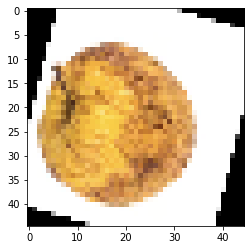

In [ ]:
x=int(input("Enter the index of any picture from the test batch to predict ie. enter a number from 1 to 10000:  "))
print("\nPrediction: \n",ypred[x])
print("\nActual: \n",Y_test[x])
print(classnames)
plt.imshow(X_test[x])

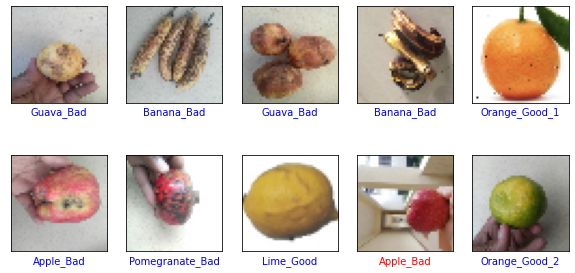

In [ ]:
visualize(X_test, Y_test, ypred)

In [ ]:
predictions = model_cnn.predict(X_test)

pred_labels = np.argmax(predictions, axis = 1)

X_test.shape

(1585, 45, 45, 3)

In [ ]:
ypred=np.argmax(ypred, axis=1)
Y_test=np.argmax(Y_test, axis=1)


In [ ]:
from sklearn.metrics import confusion_matrix,classification_report

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score


print('Confusion Matrix')

print(confusion_matrix(Y_test, ypred))

print('Classification Report')

print(classification_report(Y_test, ypred,target_names=classnames))


accuracy = accuracy_score(Y_test, ypred)
print('Accuracy: %f' % accuracy)



Confusion Matrix
[[155   2   2   0   0   0   1   0   0   0   0   0   0   0]
 [  4 120   2   0   0   5   1   1   0   1   0   3   0   2]
 [  0   0 153   0   0   0   0   0   0   0   0   0   0   0]
 [  2   0   2 134   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0 100   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0  99   0   1   0   0   0   0   0   0]
 [  0   0   0   1   0   0  99   0   0   0   0   0   0   0]
 [  0   1   0   0   0   5   0 145   0   0   0   1   0   0]
 [  0   0   0   0   0   0   1   0  98   0   0   1   0   0]
 [  7   0   2   0   0   0   0   0   0  29   2   0   0   0]
 [  0   2   0   0   0   0   0   0   0   5  31   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0 100   0   0]
 [  0   1   0   0   0   0   0   0   0   0   0   0  99   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0 165]]
Classification Report
                  precision    recall  f1-score   support

       Apple_Bad       0.92      0.97      0.95       160
      Apple_Good 

In [ ]:
tstimages, tst_lbls = data("output/test/*")

In [ ]:
test_label_ids = np.array([label_to_id_dict[x] for x in tst_lbls])
tstimages.shape, test_label_ids.shape

((10, 45, 45, 3), (10,))

In [ ]:
tst_images = tstimages/255

tst_flat = tst_images.reshape(tst_images.shape[0], 45*45*3)
tst_lbls = to_categorical(test_label_ids, 14)

print('Original Sizes Test:', tst_images.shape,tst_lbls.shape)
print('Flattened Test:', tst_flat.shape)


Original Sizes Test: (10, 45, 45, 3) (10, 14)
Flattened Test: (10, 6075)


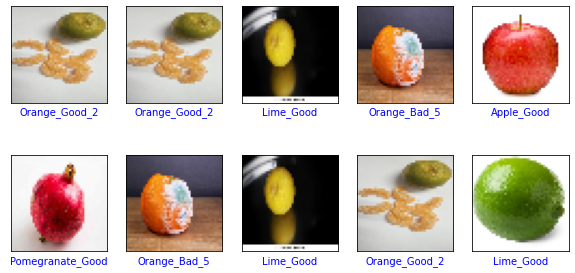

In [ ]:
visualize(tst_images, tst_lbls, tst_lbls)

In [ ]:
tst_pred = model_cnn.predict(tst_images)
print(tst_pred)




[[3.65938064e-07 5.20563148e-08 5.76421371e-06 1.24165104e-04
  7.49670101e-14 2.08028907e-11 3.39757583e-10 2.08318380e-11
  1.69458104e-07 9.99869347e-01 5.10229725e-08 3.17333786e-08
  5.65153630e-14 1.20196994e-17]
 [8.08251957e-13 3.52359134e-20 5.49895361e-18 1.89968348e-19
  2.44714094e-30 2.82242852e-30 1.91857520e-26 3.05582281e-25
  2.12669137e-20 1.00000000e+00 3.33523152e-19 7.38179529e-28
  6.35759960e-31 1.26750854e-37]
 [4.02000915e-05 9.99959826e-01 7.15147594e-20 3.04980706e-18
  1.00088865e-27 2.48243186e-15 3.00781379e-22 7.38528704e-13
  4.82577524e-25 1.56610731e-11 6.12290048e-16 6.18668762e-17
  1.48808764e-14 5.22582477e-10]
 [8.12339378e-16 2.31050235e-10 4.11413865e-19 1.63176736e-10
  7.70230391e-20 8.99902432e-07 4.00097131e-14 9.99999046e-01
  9.84881868e-17 4.52543480e-14 4.18817373e-16 3.24812470e-13
  1.41041540e-34 7.41864489e-16]
 [1.39241949e-01 2.54634291e-01 6.50828332e-02 6.76333681e-02
  5.86075941e-03 1.77661497e-02 8.99115056e-02 1.53018579e-01


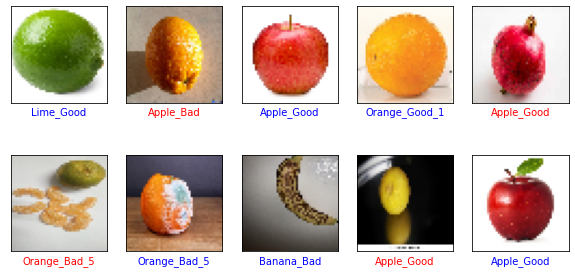

In [ ]:
visualize(tst_images, tst_lbls, tst_pred)


In [ ]:

tst_pred=np.argmax(tst_pred, axis=1)
tst_lbls=np.argmax(tst_lbls, axis=1)




In [ ]:


print('Confusion Matrix Test')

print(confusion_matrix(tst_lbls, tst_pred))

print('Classification Report')

print(classification_report(tst_lbls, tst_pred,target_names=classnames))


accuracy = accuracy_score(tst_lbls, tst_pred)
print('Accuracy: %f' % accuracy)






Confusion Matrix Test
[[154   3   1   0   0   0   1   0   0   0   2   0   0   0]
 [ 12 119   1   0   1   2   0   1   1   0   0   1   0   2]
 [  1   0 152   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   2 137   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0 100   0   0   0   0   0   0   0   0   0]
 [  0   1   0   0   0  97   0   1   0   0   0   1   0   0]
 [  0   0   0   0   0   0 100   0   0   0   0   0   0   0]
 [  0   0   0   1   0   2   0 151   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0 100   0   0   0   0   0]
 [  0   0   4   0   0   0   0   0   0  35   2   0   0   0]
 [  2   1   0   1   0   0   0   0   0   1  35   0   0   0]
 [  0   1   0   0   0   0   0   0   1   0   0  98   0   0]
 [  0   1   0   0   0   0   0   0   0   0   0   0  99   0]
 [  0   0   0   0   0   1   0   0   0   0   0   0   0 166]]
Classification Report
                  precision    recall  f1-score   support

       Apple_Bad       0.91      0.96      0.93       161
      Apple_

In [ ]:
# tstimages_m, tst_lbls_m = data("output/tst_manual/*")


# test_label_ids_m = np.array([label_to_id_dict[x] for x in tst_lbls_m])
# tstimages_m.shape, test_label_ids_m.shape


# tst_images_m = tstimages_m/255

# tst_flat_m = tst_images_m.reshape(tst_images_m.shape[0], 45*45*3)
# tst_lbls_m = to_categorical(test_label_ids_m, 14)

# print('Original Sizes Test:', tst_images_m.shape,tst_lbls_m.shape)
# print('Flattened Test:', tst_flat_m.shape)

# tst_pred_m = model_cnn.predict(tst_images_m)
# print(tst_pred_m)


# visualize(tst_images_m, tst_lbls_m, tst_pred_m)



# tst_pred=np.argmax(tst_pred_m, axis=1)
# tst_lbls=np.argmax(tst_lbls_m, axis=1)



In [ ]:
# validation_label_ids = np.array([label_to_id_dict[x] for x in vallabels])
# valimages.shape, validation_label_ids.shape